In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import cpi
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [3]:
data_salary = pd.read_csv("ds_salaries.csv")

# *Análise dos dados*

* work_year: The year the salary was paid.  
* experience_level: The experience level in the job during the year [senior, middle, junior, executive].  
* employment_type: The type of employment for the role [full-time, part-time, contractual, freelancer].
* job_title: The role worked in during the year.  
* salary: The total gross salary amount paid.  
* salary_currency: The currency of the salary paid as an ISO 4217 currency code.  
* salaryinusd: The salary in USD.  
* employee_residence: Employee's primary country of residence in during the work year as an ISO 3166 country code.  
* remote_ratio: The overall amount of work done remotely.  
* company_location: The country of the employer's main office or contracting branch.  
* company_size: The median number of people that worked for the company during the year.  

## Observações iniciais

As primeiras observações são bem superficiais, focando em ter uma visão geral de como a tabela é organizada, verificar alguns exemplos de entradas e ver algumas informações individuais das variáveis como média, variância, quantidade de valores únicos, etc. 

In [4]:
# Vendo as primeiras linhas da tabela para ter uma ideia inicial de como ela está organizada e alguns exemplos de entradas
data_salary.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [5]:
data_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [6]:
data_salary.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,3755.000000,3755,3755,3755,3.755000e+03,3755,3755.000000,3755,3755.000000,3755,3755
unique,NaN,4,4,93,NaN,20,NaN,78,NaN,72,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,2516,3718,1040,NaN,3224,NaN,3004,NaN,3040,3153
mean,2022.373635,NaN,NaN,NaN,1.906956e+05,NaN,137570.389880,NaN,46.271638,NaN,NaN
std,0.691448,NaN,NaN,NaN,6.716765e+05,NaN,63055.625278,NaN,48.589050,NaN,NaN
min,2020.000000,NaN,NaN,NaN,6.000000e+03,NaN,5132.000000,NaN,0.000000,NaN,NaN
25%,2022.000000,NaN,NaN,NaN,1.000000e+05,NaN,95000.000000,NaN,0.000000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,1.380000e+05,NaN,135000.000000,NaN,0.000000,NaN,NaN
75%,2023.000000,NaN,NaN,NaN,1.800000e+05,NaN,175000.000000,NaN,100.000000,NaN,NaN


## Tratamento dos dados

Para evitar confusão entre diferentes formas de quantificar o salário de cada posição, vamos eliminar as variáveis "salary" e "salary_currency", focando apenas em "salary_in_usd" 

In [7]:
df_salary = data_salary.drop(['salary', 'salary_currency'], axis=1)

Primeiro, vamos verificar se existem entradas repetidas e, se sim, elimina-las para evitar que o modelo de uma importância exagerada para configurações específicas que tem múltiplas entradas iguais, diminuindo riscos de overfitting

In [8]:
# Verificando a existência de entradas duplicadas
df_salary.duplicated().sum()

np.int64(1171)

In [9]:
# Retirando entradas duplicadas e redefinindo o index
df_salary = df_salary.drop_duplicates()
df_salary.reset_index(drop=True, inplace=True)

É importante também verificar e tratar de entradas vazias que podem afetar negativamente a análise e modelagem dos dados

In [10]:
# Não foram encontrados valores vazios na tabela 
df_salary.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

Para simplificar a leitura e compreensão dos dados, vamos trocar o nomes de algumas variáveis (vamos manter os nomes em inglês para serem compatíveis com o resto da tabela)

In [11]:
#  Trocar valores da coluna "experience_level"
df_salary['experience_level'] = df_salary['experience_level'].replace('EN', 'Entry-Level')
df_salary['experience_level'] = df_salary['experience_level'].replace('EX', 'Experienced')
df_salary['experience_level'] = df_salary['experience_level'].replace('MI', 'Mid-Level')
df_salary['experience_level'] = df_salary['experience_level'].replace('SE', 'Senior')
# Trocar valores da coluna "employment_type"
df_salary['employment_type'] = df_salary['employment_type'].replace('FT', 'Full-Time')
df_salary['employment_type'] = df_salary['employment_type'].replace('CT', 'Contractor')
df_salary['employment_type'] = df_salary['employment_type'].replace('FL', 'Freelancer')
df_salary['employment_type'] = df_salary['employment_type'].replace('PT', 'Part-Time')
# Trocar valores da coluna "company_size"
df_salary['company_size'] = df_salary['company_size'].replace('L', "Large")
df_salary['company_size'] = df_salary['company_size'].replace('M', "Medium")
df_salary['company_size'] = df_salary['company_size'].replace('S', "Small")

Como o principal dado da tabela é o salário em dólares de cada entrada, e as entradas se dividem em diferentes anos (entre 2020 e 2023), vamos ajudar a coluna de salários em USD para contar com a inflação e corrigir os valores para a cotação do último ano contabilizado, 2023. Como os valores estão em dólares, vamos utilizar do Consumer Price Index (CPI) para corrigir os valores

In [12]:
# Criando uma função para ajustar valores baseado em inflação
def ajustar_inflacao(entrada: pd.Series) -> pd.Series:
    entrada['salary_in_usd'] = round(cpi.inflate(entrada['salary_in_usd'], entrada['work_year'], to=2023), 2)
    return entrada

df_salary = df_salary.apply(ajustar_inflacao, axis=1)

Por fim, vamos tratar de possíveis outliers na tabela. Cortar as entradas com valores salariais mais exagerados de nossa tabela vai auxiliar a entender melhor tendencias gerais sem termos nossa análise impactada pela influência de uma entrada que se distoe muito do resto

{'whiskers': [<matplotlib.lines.Line2D at 0x13a0ff6dcd0>,
 'caps': [<matplotlib.lines.Line2D at 0x13a0ff6d4f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13a7ce60200>],
 'medians': [<matplotlib.lines.Line2D at 0x13a0ff6cf50>],
 'fliers': [<matplotlib.lines.Line2D at 0x13a0ff6cb30>],
 'means': []}

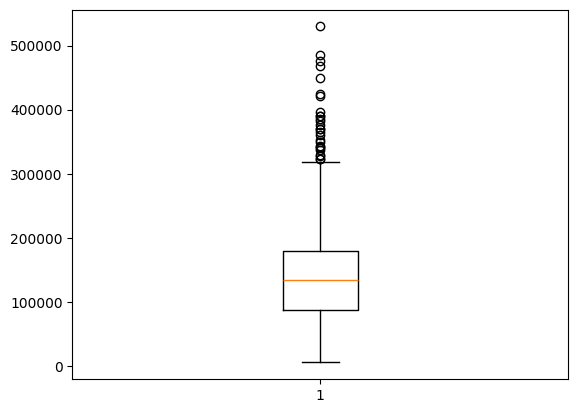

In [13]:
# O boxplot nos auxilia a visualizar a existência de possíveis outliers nos nossos dados
plt.boxplot(df_salary['salary_in_usd'])

Para eliminar esses valores, vamos cortar dados que estejam acima ou abaixo dos limites superior e inferior (nesse caso, calculados por meio dos quartis e da amplitude interquartil, respectivamente, Q3 + 1,5 * AIQ e Q1 - 1,5 * AIQ). Pelo que vemos no boxplot, não há dados abaixo do limite inferior, mas vamos fazer o processo todo para melhor compreensão. 

In [14]:
# Calculando a amplitute interquartil
Q1 = df_salary['salary_in_usd'].quantile(0.25)
Q3 = df_salary['salary_in_usd'].quantile(0.75)
AIQ = Q3 - Q1

# Removendo outliers
df_salary = df_salary.drop(df_salary[df_salary['salary_in_usd'] > (Q3 + 1.5 * AIQ)].index)
df_salary = df_salary.drop(df_salary[df_salary['salary_in_usd'] < (Q1 - 1.5 * AIQ)].index)

In [15]:
# Verificando a tabela após a limpeza e ajuste dos dados
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 0 to 2583
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           2557 non-null   int64  
 1   experience_level    2557 non-null   object 
 2   employment_type     2557 non-null   object 
 3   job_title           2557 non-null   object 
 4   salary_in_usd       2557 non-null   float64
 5   employee_residence  2557 non-null   object 
 6   remote_ratio        2557 non-null   int64  
 7   company_location    2557 non-null   object 
 8   company_size        2557 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 199.8+ KB


In [16]:
df_salary.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,2557.000000,2557,2557,2557,2557.000000,2557,2557.000000,2557,2557
unique,NaN,4,4,92,NaN,77,NaN,72,3
top,NaN,Senior,Full-Time,Data Engineer,NaN,US,NaN,US,Medium
freq,NaN,1537,2521,595,NaN,1868,NaN,1904,2011
mean,2022.302698,NaN,NaN,NaN,134630.857673,NaN,50.508408,NaN,NaN
std,0.746329,NaN,NaN,NaN,63883.531654,NaN,48.164019,NaN,NaN
min,2020.000000,NaN,NaN,NaN,5343.260000,NaN,0.000000,NaN,NaN
25%,2022.000000,NaN,NaN,NaN,87316.220000,NaN,0.000000,NaN,NaN
50%,2022.000000,NaN,NaN,NaN,132227.890000,NaN,50.000000,NaN,NaN
75%,2023.000000,NaN,NaN,NaN,178500.000000,NaN,100.000000,NaN,NaN


## Análise comparativa dos dados

<BarContainer object of 4 artists>

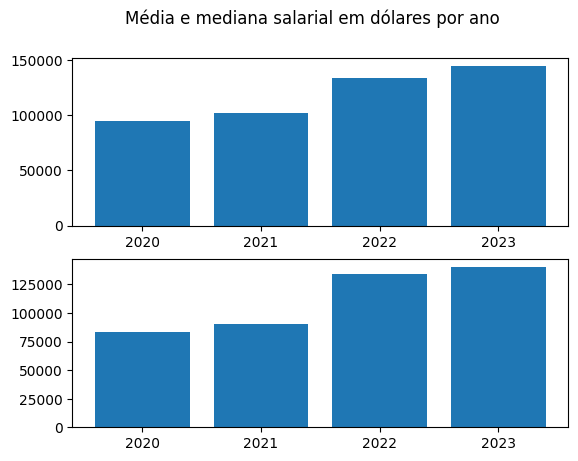

In [17]:
# Observar a média e mediana salarial em dólares por ano
fig, axes = plt.subplots(2)

fig.suptitle("Média e mediana salarial em dólares por ano")

years = [str(value) for value in df_salary.work_year.sort_values().unique()]
y0 = df_salary.groupby('work_year').mean(numeric_only=True).salary_in_usd
y1 = df_salary.groupby('work_year').median(numeric_only=True).salary_in_usd

axes[0].bar(years, y0)
axes[1].bar(years, y1)

Text(0.5, 1.0, '2023')

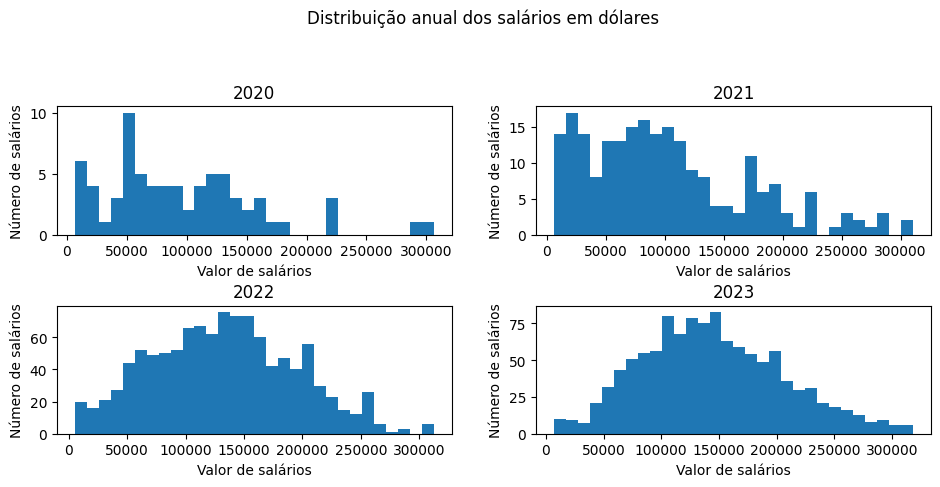

In [18]:
# Distribuição anual dos salários em dólares
fig, axes = plt.subplots(2,2)

fig.suptitle("Distribuição anual dos salários em dólares")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=3.0)

years = df_salary.work_year.sort_values().unique()
data = []
for i in range(0, 4):
    data.insert(i,df_salary['salary_in_usd'][df_salary['work_year'] == years[i]])

for ax in axes.ravel():
    ax.set_ylabel('Número de salários')
    ax.set_xlabel('Valor de salários')

bins = 30

axes[0,0].hist(data[0], bins=bins)
axes[0,0].set_title(years[0])

axes[0,1].hist(data[1], bins=bins)
axes[0,1].set_title(years[1])

axes[1,0].hist(data[2], bins=bins)
axes[1,0].set_title(years[2])

axes[1,1].hist(data[3], bins=bins)
axes[1,1].set_title(years[3])

([<matplotlib.patches.Wedge at 0x13a0eac9b50>,
 [Text(-0.3435156762082209, 1.0449865933107512, 'Senior'),
  Text(-0.13682056301467518, -1.0914578019952708, 'Mid-Level'),
  Text(0.9361168739351365, -0.577654912844951, 'Entry-Level'),
  Text(1.093281973526715, -0.12138585733738293, 'Experienced')],
 [Text(-0.18737218702266592, 0.5699926872604096, '60.1%'),
  Text(-0.07462939800800464, -0.5953406192701476, '25.8%'),
  Text(0.5106092039646198, -0.31508449791542775, '10.6%'),
  Text(0.5963356219236626, -0.0662104676385725, '3.5%')])

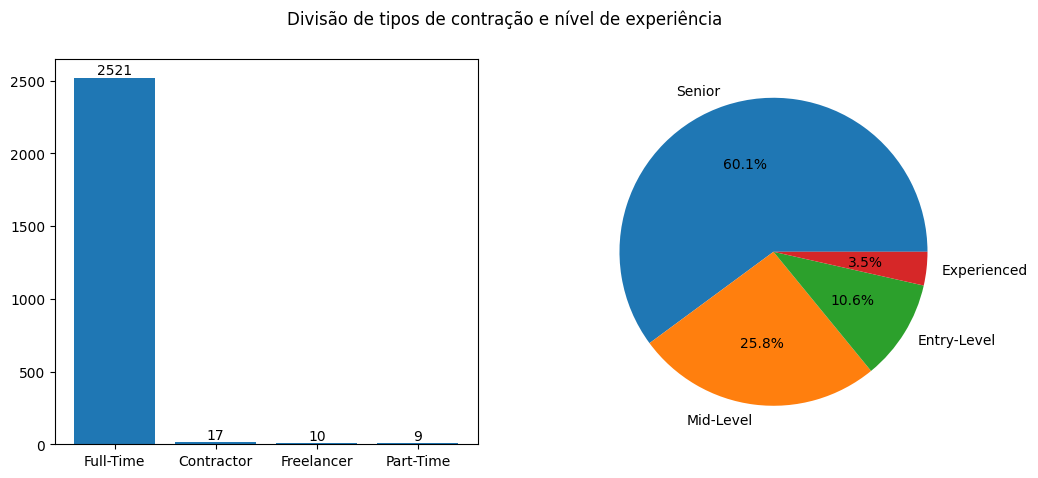

In [29]:
# Visualizando a divisão de tipos de contração e nível de experiência
fig, axes = plt.subplots(1, 2)

fig.suptitle("Divisão de tipos de contração e nível de experiência")
fig.set_size_inches(12, 5)

bars = axes[0].bar(x=df_salary['employment_type'].unique(), height=df_salary['employment_type'].value_counts())
axes[0].bar_label(bars, labels=[x.get_height() for x in bars])
axes[1].pie(x=df_salary['experience_level'].value_counts(), labels=df_salary['experience_level'].unique(), autopct='%1.1f%%')

(0.0, 200000.0)

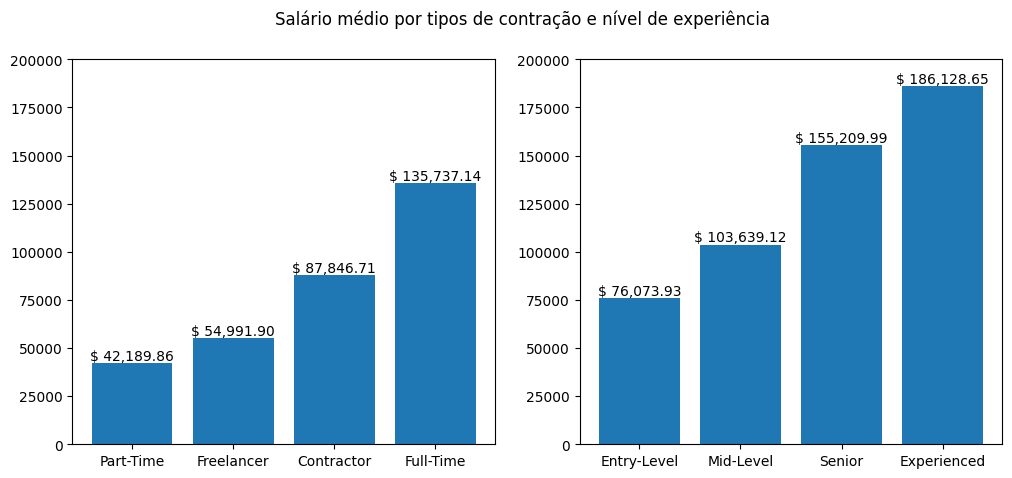

In [20]:
# Visualizando o salário médio por tipos de contração e nível de experiência
fig, axes = plt.subplots(1, 2)

fig.suptitle("Salário médio por tipos de contração e nível de experiência")
fig.set_size_inches(12, 5)

salario_medio_contrato = df_salary.groupby('employment_type')['salary_in_usd'].mean().sort_values().reset_index()
salario_medio_experiencia = df_salary.groupby('experience_level')['salary_in_usd'].mean().sort_values().reset_index()

bars0 = axes[0].bar(x=salario_medio_contrato['employment_type'], height=salario_medio_contrato['salary_in_usd'])
axes[0].bar_label(bars0, labels=[f"${x.get_height(): ,.2f}" for x in bars0])
axes[0].set_ylim([0, 200000])
bars1 = axes[1].bar(x=salario_medio_experiencia['experience_level'], height=salario_medio_experiencia['salary_in_usd'])
axes[1].bar_label(bars1, labels=[f"${x.get_height(): ,.2f}" for x in bars1])
axes[1].set_ylim([0, 200000])

(0.0, 200000.0)

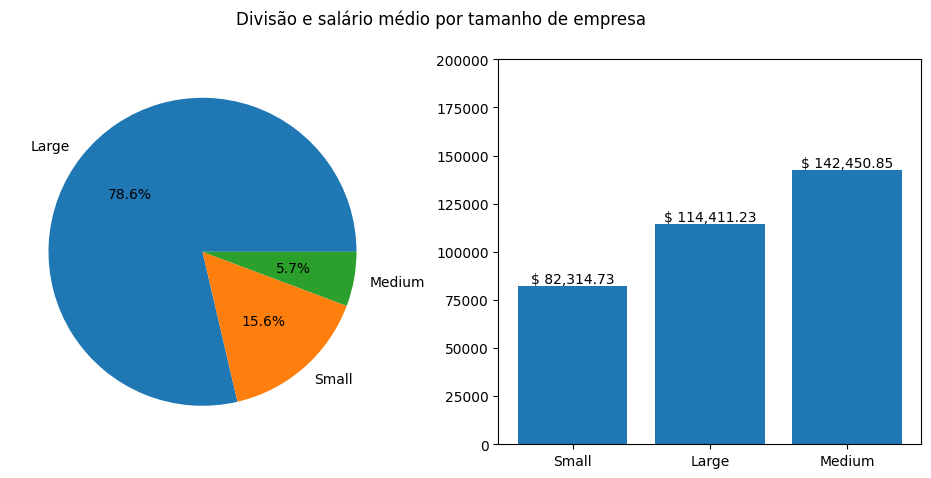

In [25]:
# Visualizando a divisão por tamanho de empresa e o salário médio em cada tamanho de empresa
fig, axes = plt.subplots(1, 2)

fig.suptitle("Divisão e salário médio por tamanho de empresa")
fig.set_size_inches(12, 5)

salario_medio_tamanho_empresa = df_salary.groupby('company_size')['salary_in_usd'].mean().sort_values().reset_index()

axes[0].pie(x=df_salary['company_size'].value_counts(), labels=df_salary['company_size'].unique(), autopct='%1.1f%%')
bars1 = axes[1].bar(x=salario_medio_tamanho_empresa['company_size'], height=salario_medio_tamanho_empresa['salary_in_usd'])
axes[1].bar_label(bars1, labels=[f"${x.get_height(): ,.2f}" for x in bars1])
axes[1].set_ylim([0, 200000])

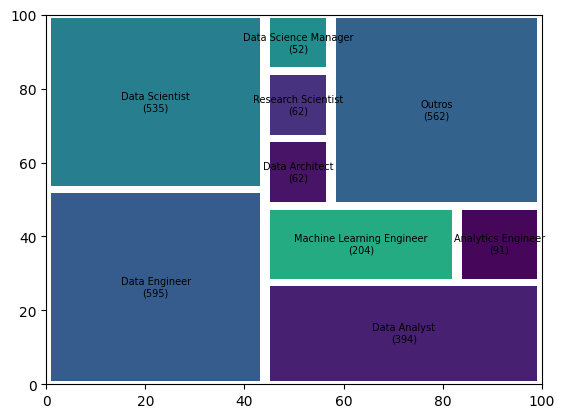

<Figure size 640x480 with 0 Axes>

In [22]:
# Visualizando os títulos de emprego mais populares
titulos_emprego = df_salary['job_title'].value_counts()

valor_outros = 0
for value in titulos_emprego.index:
    if titulos_emprego[value] <=40:
        valor_outros += titulos_emprego[value]
        titulos_emprego.drop(labels=[value], inplace=True)
titulos_emprego = pd.concat([titulos_emprego, pd.Series(data=[valor_outros], index=["Outros"])])

labels = [f"{titulo}\n({quantidade})" for titulo, quantidade in zip(titulos_emprego.index, titulos_emprego)]

squarify.plot(sizes=titulos_emprego, label=labels, pad=True, text_kwargs={'fontsize':7})
plt.figure()
plt.show()

In [23]:
# Visualizando os países em que 

['Data Engineer\n(595)',
 'Data Scientist\n(535)',
 'Data Analyst\n(394)',
 'Machine Learning Engineer\n(204)',
 'Analytics Engineer\n(91)',
 'Data Architect\n(62)',
 'Research Scientist\n(62)',
 'Data Science Manager\n(52)',
 'Outros\n(562)']

In [36]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2557 entries, 0 to 2583
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   work_year           2557 non-null   int64  
 1   experience_level    2557 non-null   object 
 2   employment_type     2557 non-null   object 
 3   job_title           2557 non-null   object 
 4   salary_in_usd       2557 non-null   float64
 5   employee_residence  2557 non-null   object 
 6   remote_ratio        2557 non-null   int64  
 7   company_location    2557 non-null   object 
 8   company_size        2557 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 199.8+ KB


##  Prevendo salário através de uma árvore de decisão

In [43]:
# Separando as variáveis independentes e a variávei dependente
variaveis_independentes = ['work_year', 'experience_level', 'employment_type', 'company_size']
X = df_salary[variaveis_independentes]
Y = df_salary['salary_in_usd']

In [44]:
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), variaveis_independentes)], remainder='passthrough')

In [46]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [39]:
# Separando os dados em sets de treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [47]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['work_year',
                                                   'experience_level',
                                                   'employment_type',
                                                   'company_size'])])),
                ('regressor', DecisionTreeRegressor(random_state=42))])

In [48]:
Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3297435219.1710677


In [50]:
Y_test

2213    277366.23
590      48289.00
181     190000.00
2117    224162.72
299     222000.00
          ...    
1112    219000.00
1282     33103.83
1485    199070.65
445     190000.00
948     195800.00
Name: salary_in_usd, Length: 640, dtype: float64